## Comparing survey footprints

Q1 in the Cadence Notes call asks "Is it preferable to cover 18k sq degrees or 20k square degrees in the WFD?" The assumption here is that the total number of visits in the WFD is held about constant, which means that with a 10% increase in area, there would be a reduction in visits per pointing of about 10% to match. 

At the highest level Q1 should definitely be addressed in the spirit of: would you trade number of visits for area or would you prefer vice versa? Of course, there are complications to this question -- the primary one being "Where is this area distributed?". For science which requires low dust extinction, adding 2k sq degrees in the galactic plane is not helpful, and for science which is focused on stellar populations near the galactic plane, adding 2k sq degrees at high galactic latitudes is not necessarily helpful either. 

Leaving that aside for now, a helpful question that we can answer is "How does the WFD area vary within the current set of simulations?" and "How much area do we think we could practically include in the WFD?"

### How much area is covered in the current simulations in the WFD?

We can look at fOArea to check how much area is included in the WFD, however, this uses 825 visits per pointing as the 'cutoff' for counting up that area. The minimum design specification for the WFD is not 825, it's 750 visits per pointing -- so it's useful to evaluate how much area is included in the survey footprint at 750, 825, and 900 (as a choice of a higher 'goal' number of visits).  This is a new summary metric that was not previously available, but it's easily calculable from the nvisits_maps which are available as pre-generated MAF outputs.

It's worth noting that for simulations which fall short of this particular number of visits per pointing, the related area will drop quite sharply. The number of visits per pointing is likely to be falling more gently, but since the visits are distributed fairly evenly over the sky, as soon as these visits drop below the threshold, the area above that threshold drops very quickly.

Another complication is that most of the v1.5 simulations use 1x30s visits, while the v1.7 simulations use 2x15s visits. In itself, this isn't necessarily a problem: when comparing the effects of varying the survey strategy within a family, almost all of the time the fact that both the comparison simulation and the simulation with the survey strategy variation had 9% more or less visits than they might otherwise doesn't affect the evaluation of the variation. However, this is one of the times when it might matter, because we'd like to look at the area and number of visits of all simulations together.  I could still look at the amount of area covered to a given number of visits and ignore the fact that this means the WFD is taking more or less of the overall fraction of time, OR I could try to correct the number of visits for the fact that a 1x30s visit simulation can achieve about 9% more visits than a 2x15s simulation. I will try the latter - correction the required number of visit thresholds by 9.22% depending on the number of snaps per visit in the simulation. 

In [1]:
# Import generally useful packages
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import pandas as pd
import healpy as hp
import copy

In [2]:
# Import MAF modules 
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as mb

In [3]:
import run_infos as ri

We'll load up previously calculated 'number of visits per pointing' maps (see [FootprintMaps.ipynb](https://github.com/lsst-pst/survey_strategy/blob/master/fbs_1.7/FootprintMaps.ipynb)) and then calculate new fO_Area values, with the 750/825/900 cutoffs (but adjust these thresholds upward by 9% for simulations using 1x30s visits).

In [4]:
# Let's make this easier to get the right filename: 
metricNameDict = {'Nvisits_all': '_NVisits_Visitsgt10s_all_bands_HEAL',
                  'Nvisits_u': '_NVisits_Visitsgt10s_u_band_HEAL',
                  'Nvisits_g': '_NVisits_Visitsgt10s_g_band_HEAL',
                  'Nvisits_r': '_NVisits_Visitsgt10s_r_band_HEAL',
                  'Nvisits_i': '_NVisits_Visitsgt10s_i_band_HEAL',
                  'Nvisits_z': '_NVisits_Visitsgt10s_z_band_HEAL',
                  'Nvisits_y': '_NVisits_Visitsgt10s_y_band_HEAL',
                  'Coadd_u': '_CoaddM5_Visitsgt10s_u_band_HEAL',
                  'Coadd_g': '_CoaddM5_Visitsgt10s_g_band_HEAL',
                  'Coadd_r': '_CoaddM5_Visitsgt10s_r_band_HEAL',
                  'Coadd_i': '_CoaddM5_Visitsgt10s_i_band_HEAL',
                  'Coadd_z': '_CoaddM5_Visitsgt10s_z_band_HEAL',
                  'Coadd_y': '_CoaddM5_Visitsgt10s_y_band_HEAL'}

nvisitsMapsDir = '/local/lsst/opsim/nvisits_maps'

In [5]:
# We'll use FamilyInfo to help get the sim names in 'order'
families = ri.FamilyInfo()
families.read_summary_csv()
familylist = families.list_of_families()

**visit_time**, with 3 simulations.<br>**u_long**, with 5 simulations.<br>**intranight**, with 9 simulations.<br>**pair_times**, with 6 simulations.<br>**twilight_pairs**, with 5 simulations.<br>**wfd_depth**, with 17 simulations.<br>**filter_dist**, with 8 simulations.<br>**footprint**, with 19 simulations.<br>**footprint_tune**, with 10 simulations.<br>**filter_cadence**, with 7 simulations.<br>**alt_rolling**, with 3 simulations.<br>**rolling**, with 25 simulations.<br>**twilight_neo**, with 8 simulations.<br>**shortexp**, with 5 simulations.<br>**dcr**, with 7 simulations.<br>**good_seeing**, with 6 simulations.<br>**spiders**, with 2 simulations.<br>**ddf**, with 4 simulations.<br>**ddf_dithers**, with 9 simulations.<br>**euclid_dithers**, with 6 simulations.<br>**potential_schedulers**, with 17 simulations.<br>

For 181 simulations in all.


In [6]:
# Read the files from disk.
bundles = {}
for fam in familylist:
    for r in families.family[fam]:
        bundles[r] = mb.createEmptyMetricBundle()
        # Note that '.' is replaced by "_" in the filenames!
        bundles[r].read(os.path.join(nvisitsMapsDir, 'npz', 
                                     f'{r.replace(".", "_")}{metricNameDict["Nvisits_all"]}.npz'))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

### Calculate and compare footprint area


To correct for the exposure time, we should check the typical 'nexposures' in each simulation (together with the visitExposureTime this tells you if it's 1x30s or 2x15s=30s onsky). 
I ran these as metrics elsewhere but let's read in the metric results and add it into our outputs. 

In [7]:
# Read in median exposure time values.
newvalues = {}
keys = ['Mean ExpTime', 'Median ExpTime', 'NumExp']
metricnames = ['Mean_visitExposureTime', 'Median_visitExposureTime', 'Median_numExposures']

for k in keys:
    newvalues[k] = {}

for r in bundles:
    for k, mname in zip(keys, metricnames):
        tmp = mb.createEmptyMetricBundle()
        tmp.read(os.path.join(nvisitsMapsDir, 'exptime',
                             f'{r.replace(".", "_")}_{mname}_all_visits_UNIS.npz'))
        newvalues[k][r] = tmp.metricValues[0]

newdata = pd.DataFrame([newvalues[k] for k in keys], index=keys).T
newdata

,Mean ExpTime,Median ExpTime,NumExp
baseline_v1.5_10yrs,30.000000,30.0,1.0
baseline_2snaps_v1.5_10yrs,30.000000,30.0,2.0
var_expt_v1.5_10yrs,32.232595,24.0,1.0
baseline_nexp2_v1.7_10yrs,30.000000,30.0,2.0
u_long_ms_30_v1.7_10yrs,30.000000,30.0,2.0
...,...,...,...
mw_heavy_v1.6_10yrs,30.000000,30.0,1.0
rolling_exgal_mod2_dust_sdf_0.80_nexp2_v1.6_10yrs,30.000000,30.0,2.0
rolling_exgal_mod2_dust_sdf_0.80_v1.6_10yrs,30.000000,30.0,1.0
ss_heavy_nexp2_v1.6_10yrs,25.316181,30.0,2.0


In [8]:
# Join with existing summary stat dataframe.
families.summaries = families.summaries.join(newdata, how='left')

So now, I'll just adjust the boundary values by 9% depending on whether the run was 1x30s or 2x15s. For the variable exposure time run, the intent was to make it 1xXseconds, so will adjust thresholds upwards by 9% too, but this isn't quite accurate for this run as the final mean exposure time was longer than 30s (even though the median was shorter). 

In [9]:
nside = 64 # as above
thresholds_2snaps = np.array([750, 825, 900])
thresholds_1snap = np.floor(thresholds_2snaps / 0.922)
print(thresholds_2snaps, thresholds_1snap)

[750 825 900] [813. 894. 976.]


In [10]:
runs = []
for r in bundles:
    runs.append(r)
    if families.summaries['NumExp'].loc[r] > 1.5:
        threshold = thresholds_2snaps
    else:
        threshold = thresholds_1snap
    foA = {}
    foA['min'] = metrics.fOArea(nside=nside, Nvisit=threshold[0], norm=False, metricName='fOArea Min')
    foA['goal'] = metrics.fOArea(nside=nside, Nvisit=threshold[1], norm=False, metricName='fOArea Goal')
    foA['stretch'] = metrics.fOArea(nside=nside, Nvisit=threshold[2], norm=False, metricName='fOArea Stretch')
    bundles[r].setSummaryMetrics([foA[n] for n in foA])
    bundles[r].computeSummaryStats()

In [11]:
newdata = pd.DataFrame([bundles[r].summaryValues for r in bundles], index=runs)
newdata[0:5]

,fOArea Min,fOArea Goal,fOArea Stretch
baseline_v1.5_10yrs,18252.118902,18035.581142,6821.778748
baseline_2snaps_v1.5_10yrs,18266.386894,17996.134341,7112.174350
var_expt_v1.5_10yrs,18136.296379,13124.874024,334.878164
baseline_nexp2_v1.7_10yrs,18233.654442,17982.705642,5968.217111
u_long_ms_30_v1.7_10yrs,18296.601466,18091.813816,10222.596599


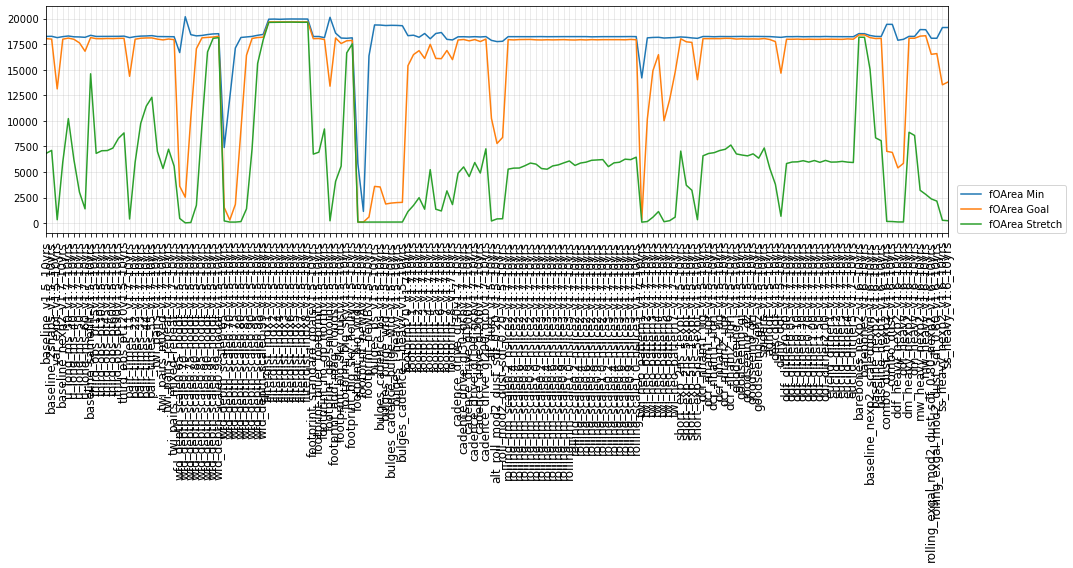

In [12]:
ri.plot(newdata, normed=False, figsize=(15, 8))

You can see some spikes here where the area covered to 750 visits increases, while the area covered to 825 or 900 visits drops - this indicates there were enough visits to cover a larger area, but not enough to cover it to that many visits. You can also see some runs where everything dropped, like the wfd_depth_scale0.60 or twi_neo_pattern1 .. in these cases, it's not that we reduced the area in the WFD, it's just that we don't have time spent on WFD to even cover that area to 750 visits.

In [13]:
# Add these new summary metrics into the existing summaries.
families.summaries = families.summaries.join(newdata, how='left')

We can also take a moment to just visualize how much area is covered in each simulation, with what number of visits:

(19063.649643116732, 25021.04015659071)

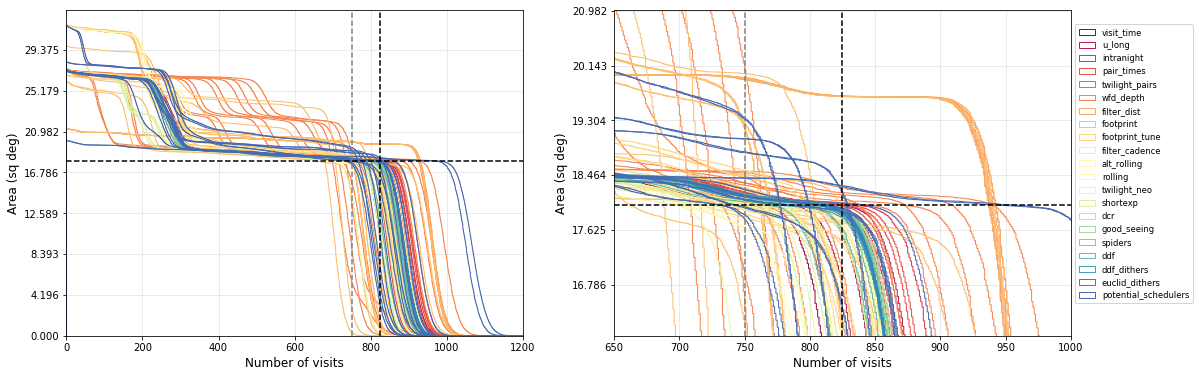

In [14]:
# Plot the histogram of the number of visits .. 
# the HealpixHistogram or FoPlotter does this nicely, but this was easier for colors

def mjrFormatter(y, pos):
    return '%.3f' % (y * scale)


plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
bins = np.arange(0, 1200, 1)
cmap = cm.get_cmap('Spectral')
for i_fam, fam in enumerate(familylist):
    i = 0
    color = cmap(i_fam/len(familylist))
    for r in families.family[fam]:
        if i == 0:
            label=fam
            i += 1
        else:
            label=None
        if families.summaries['NumExp'].loc[r] > 1.1:
            corr = 1.0
        else:
            corr = 0.91
        plt.hist(bundles[r].metricValues.compressed()*corr, bins=bins, cumulative=-1, histtype='step',  
                 color=[color], label=label)
plt.xlim(0, 1200)

scale = hp.nside2pixarea(nside, degrees=True) / 1000.0
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(mjrFormatter))
 
plt.axvline(825, color='k', linestyle='--')
plt.axvline(750, color='gray', linestyle='--')
plt.axhline(18/scale, color='k', linestyle='--')

plt.grid(True, alpha=0.3)
plt.xlabel("Number of visits", fontsize='larger')
plt.ylabel("Area (sq deg)", fontsize='larger')
#plt.legend(loc=(1.01, 0.1), fontsize='smaller')

plt.subplot(1, 2, 2)

bins = np.arange(0, 1200, 1)
cmap = cm.get_cmap('Spectral')
for i_fam, fam in enumerate(familylist):
    i = 0
    color = cmap(i_fam/len(familylist))
    for r in families.family[fam]:
        if i == 0:
            label=fam
            i += 1
        else:
            label=None
        if families.summaries['NumExp'].loc[r] > 1.1:
            corr = 1.0
        else:
            corr = 0.922
        plt.hist(bundles[r].metricValues.compressed()*corr, bins=bins, cumulative=-1, histtype='step',  
                 color=[color], label=label)
plt.xlim(0, 1200)

scale = hp.nside2pixarea(nside, degrees=True) / 1000.0
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(mjrFormatter))
 
plt.axvline(825, color='k', linestyle='--')
plt.axvline(750, color='gray', linestyle='--')
plt.axhline(18/scale, color='k', linestyle='--')

plt.grid(True, alpha=0.3)
plt.xlabel("Number of visits", fontsize='larger')
plt.ylabel("Area (sq deg)", fontsize='larger')
plt.legend(loc=(1.01, 0.1), fontsize='smaller')
plt.xlim(650, 1000)
plt.ylim(16/scale, 21/scale)

This plot shows number of visits on the X axis and (as a cumulative histogram) it shows the number of healpixels which have at least this many visits on the Y axis. The right-hand plot is just a zoomed-in version of the left-hand plot. 

From left to right, the lines trend downward because less area has 'at least this many visits'. There's a convergence at around 18k sq deg/825 visits, because this is where we typically aim the simulations. Runs with more weight or time available for the WFD have more visits over this area; we have very few simulations where we put WFD-level number of visits into a significantly larger area.

### Which simulations show the widest range in area covered in the WFD (using the minimum number of visits per pointing, 750)?

                                        fOArea Min   fOArea Goal
baseline_samefilt_v1.5_10yrs          18362.905664  18139.653554
baseline_nexp2_scaleddown_v1.6_10yrs  18346.119791  18138.814260
baseline_2snaps_v1.5_10yrs            18266.386894  17996.134341
baseline_nexp2_v1.6_10yrs             18257.993958  18044.813372
baseline_v1.5_10yrs                   18252.118902  18035.581142
baseline_nexp1_v1.6_10yrs             18245.404553  18064.117126
baseline_nexp2_v1.7_10yrs             18233.654442  17982.705642


(17000.0, 20000.0)

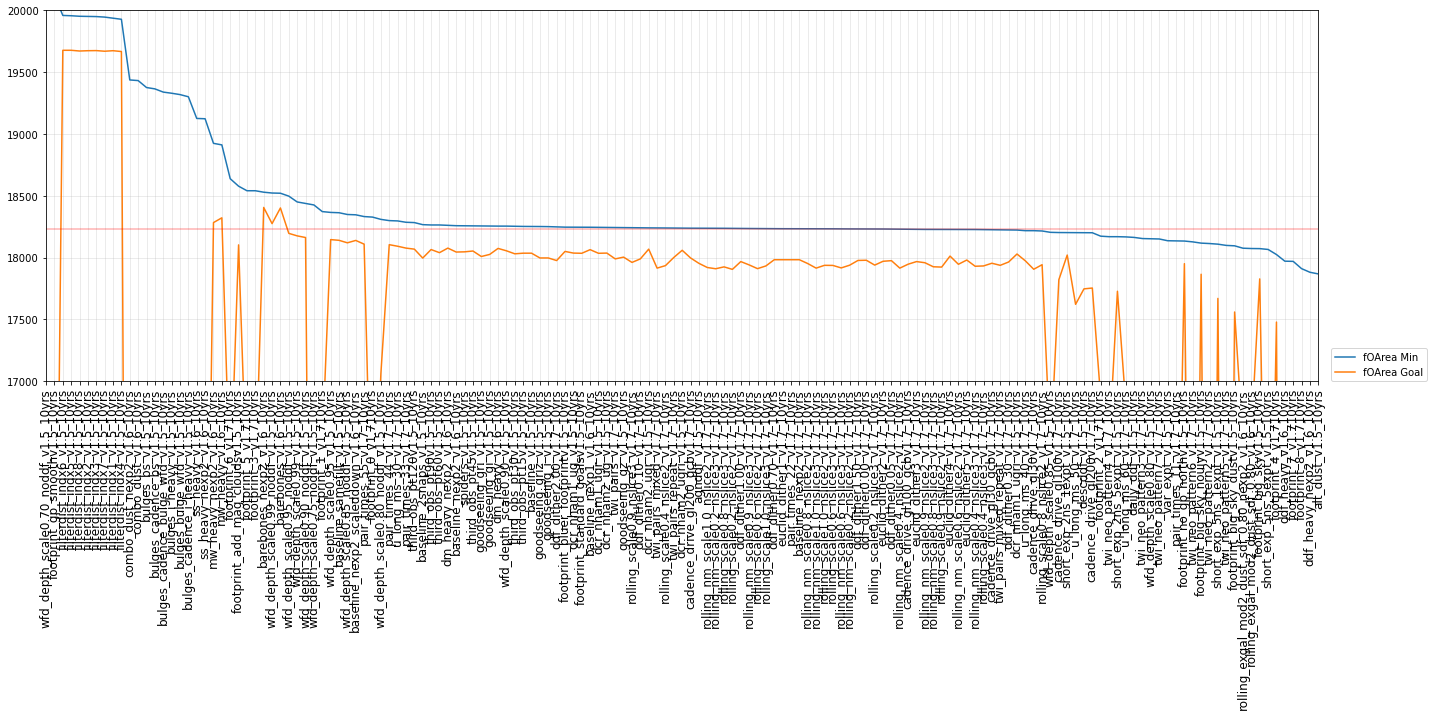

In [15]:
val = families.summaries['fOArea Min']
test = val[val>17800].sort_values(ascending=False)

baselines = [r for r in test.index if 'baseline' in r]
print(families.summaries[['fOArea Min', 'fOArea Goal']].loc[baselines])

mlist = ['fOArea Min', 'fOArea Goal']
ri.plot(families.summaries[mlist].loc[test.index], normed=False, figsize=(20, 10))
plt.axhline(18230, color='r', alpha=0.3)
plt.ylim(17000, 20000)

There is a long plateau at about 18230 sq deg, which correlates with the 'standard footprint' (see baselines fall in near this value). The area which reached 825 visits per pointing follows along pretty uniformly with this plateau as well; these runs are behaving similarly in their overall footprint configuration.

Some footprints raise above this limit by a small amount - these are footprints which might be interesting for this question, but let's investigate them further.

(18200.0, 20200.0)

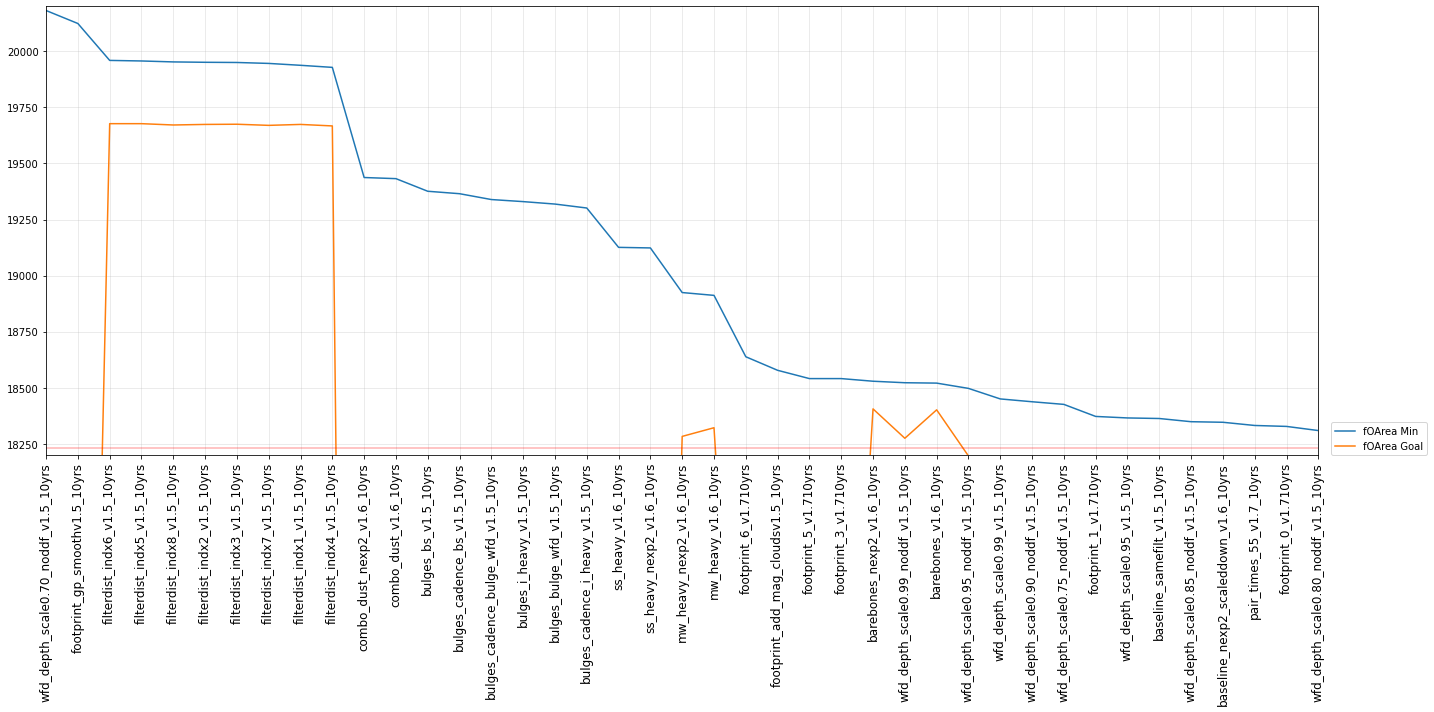

In [16]:
test = val[val>18300].sort_values(ascending=False)

mlist = ['fOArea Min', 'fOArea Goal']
ri.plot(families.summaries[mlist].loc[test.index], normed=False, figsize=(20, 10))
plt.axhline(18230, color='r', alpha=0.3)
plt.ylim(18200, 20200)

`footprint_gp_smoothv1.5_10yrs` includes the maximum amount of area, followed closely by the `filter_dist` family. Both of these runs extend the WFD through the galactic plane; footprint_gp_smooth distributes a small proportion of visits to the NES and SCP, while the filter_dist family is strictly a dec-limited footprint corresponding to the limits of the traditional WFD. 

The next few runs are a mix. The run `wfd_depth_scale_0.70_noddf_v1.5_10yrs` reaches a large amount of area somewhat by chance, as here there are enough visits in the WFD to reach the 750 visits per pointing threshold, but enough visits left over that they are shunted into the NES and then that area *also* reaches 750 visits per pointing. 
The `combo_dust` run is an early prototype of what ended up as the `footprint_tune` family, but which did not leave a comfortable 'reserve' in WFD visits - thus the slightly more conservative `footprint_*` simulations from the `footprint_tune` family also show up here, but with a slightly smaller area (due to having a slightly smaller 'bridge' and 'galactic plane' area, as well as a slightly trimmed down WFD). The `bulges_bs` and `bulges_cadence_bs` use a large-volume (extended N/S limits, but with coverage extended toward the galactic plane compared to `footprint_big_skyv1.5_10yrs` or any of the other dust-extinction limited WFDs) WFD, but very little coverage in the galactic plane. The other `bulges_*` runs are similar, although start to add more coverage toward the galactic bulge - the area here is still primarily coming from the large WFD.

Some other runs worth noting: the `barebones_*` and `wfd_depth_scale_*` runs where the 'scale' is >0.90% (e.g. `wfd_depth_scale0.99_v1.5_10yrs` run) -- these are cases where the standard traditional WFD footprint is used, and heavily (or exclusively) favored. These runs seem to peek above the 18230 sq deg 'fOArea Min' threshold not because any area is added to the footprint, but because the footprint itself is covered more heavily, including at the very edges. In general, the dithering required to smooth the sky coverage leaves the edges of the footprint with a fewer number of visits; in cases where the overall number of visits inside the footprint is very high, even the edge will meet this criteria of at least 750 visits per pointing. You can see this also shows up at the 825 visit per pointing threshold as well. 

### Potential simulations to think about further

A few highlight examples of runs which try to maximize area for particular science or purposes:

* `baseline_nexp2_v1.7_10yrs` (or any of the other baselines) as the standard 18k sq degree example. 
* `footprint_gp_smoothv1.5_10yrs` or any of the `filter_dist` family as an example of adding more area toward the galactic plane
* `bulges_cadence_bs_v1.5_10yrs` or similar as an example of adding more area in the WFD plus extended that area toward the outer parts of the galactic plane
* `wfd_depth_scale0.70_noddf_v1.5_10yrs` as an example of adding more coverage to the NES while maintaining a traditional WFD
* `combo_dust_nexp2_v1.6_10yrs` as an example of trying to do it all (more area in the WFD, adding area in the bulge, adding a 'bridge' across the galactic plane at higher galactic latitudes -- but cutting the limit close on how many visits are available per pointing, everywhere
* `footprint_6_v1.710yrs` as a best example of adding more low-dust-extinction WFD area while also adding area toward the galactic bulge, Magellanic Clouds, and a 'bridge' across the galactic plane at higher galactic latitude
* `footprint_8_v1.710yrs` as an example not necessarily of more area (it doesn't show up above, after all) but of adding extragalactic-focused area while maintaining a larger number of visits per pointing
   
These runs can't all be compared against each other directly, because of the variable total number of visits; compare each one against their relevant baseline to see if your metric improved or got worse. It's important to consider not just the amount of area covered, but also the number of visits per pointing; in these simulations, the amount of total time devoted to WFD/high-visit area is NOT CONSTANT.

In [31]:
# Let's give a rough try though, to at least identify possible issues
simlist = ['baseline_nexp2_v1.7_10yrs', 
           'footprint_gp_smoothv1.5_10yrs', 
           'bulges_cadence_bs_v1.5_10yrs',
           'wfd_depth_scale0.70_noddf_v1.5_10yrs',
           'combo_dust_nexp2_v1.6_10yrs', 
           'footprint_6_v1.710yrs', 
           'footprint_8_v1.710yrs']

mlist = ['Nvisits Long Exp', 'fONv MedianNvis fO All visits HealpixSlicer', 
         'fOArea Min',# 'fOArea Goal', 'fOArea Stretch',
        'Effective Area (deg) ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer']
mlist_shortnames = ['Total Nvisits*', 'Median Nvisits per pointing*',
                    'fOArea Min', #'fOArea Goal', 'fOArea Stretch',
                    'Dust-free deep area']

d = families.summaries[mlist].loc[simlist]

# Scale the nvisits metric results down to match 9% fewer overall visits
# Note that the fOArea metrics *here* already reflect this scaling; 
# effective area does not but may not be as sensitive.
visitmetrics = ['Nvisits Long Exp', 'fONv MedianNvis fO All visits HealpixSlicer']
onesnap = np.where(families.summaries['NumExp'].loc[simlist] == 1)
for r in d.index.values[onesnap]:
    for m in visitmetrics:
        #  0.922 factor finetuned by comparing nexp1 and nexp2 runs in the potential_schedulers family
        d[m].loc[r] = d[m].loc[r] * 0.922 
d.columns = mlist_shortnames
d

,Total Nvisits*,Median Nvisits per pointing*,fOArea Min,Dust-free deep area
baseline_nexp2_v1.7_10yrs,2045493.000,888.000,18233.654442,15174.429105
footprint_gp_smoothv1.5_10yrs,2050300.266,837.176,20123.743731,15184.500629
bulges_cadence_bs_v1.5_10yrs,2055496.658,803.984,19365.022276,17239.091473
wfd_depth_scale0.70_noddf_v1.5_10yrs,2053689.538,796.608,20181.654993,15422.860024
combo_dust_nexp2_v1.6_10yrs,2069774.000,817.000,19437.201529,17063.679101
footprint_6_v1.710yrs,2044789.000,856.000,18638.193979,16438.405335
footprint_8_v1.710yrs,2050183.000,860.000,17910.526389,17413.664551


(0.8, 1.2)

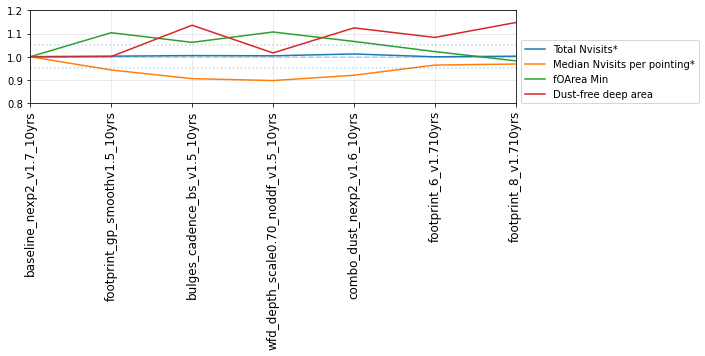

In [32]:
dn = d / d.loc['baseline_nexp2_v1.7_10yrs']
ri.plot(dn, normed=True, figsize=(10, 5))
plt.ylim(0.8, 1.2)

The plot above shows the total number of visits holds roughly constant after adjusting for the typical difference between 2x15s and 1x30s simulations, although the Median Number of visits per pointing (which would be in the WFD) varies by about 10%; this gives you some indication of the overall amount of time devoted to 'WFD' in each simulation.
While the total amount of survey area varies, the placement of the area also varies - this can be seen in the variation of the 'dust-free' survey area. 

/ssd/lsst/lsst_stack_w_2021_12/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.3/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/ssd/lsst/lsst_stack_w_2021_12/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.3/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/ssd/lsst/lsst_stack_w_2021_12/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.3/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and 

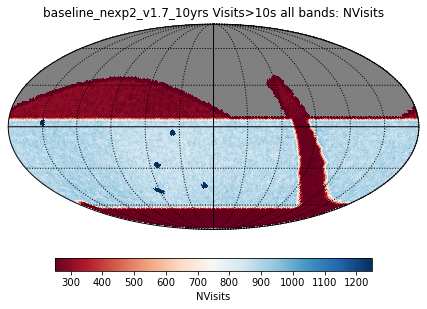

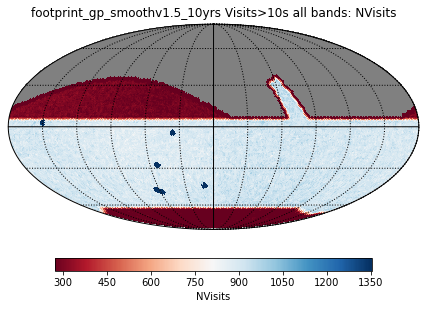

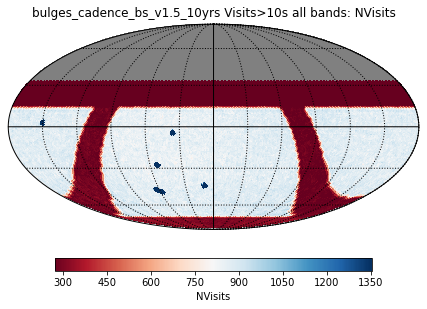

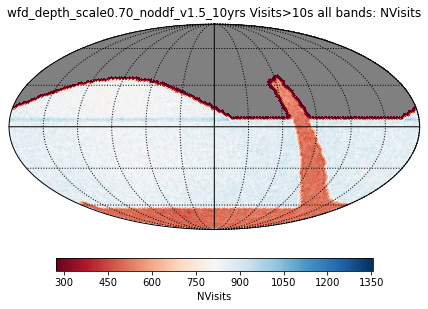

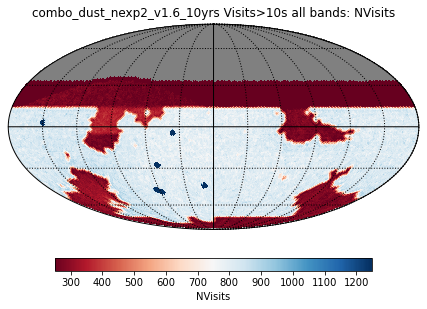

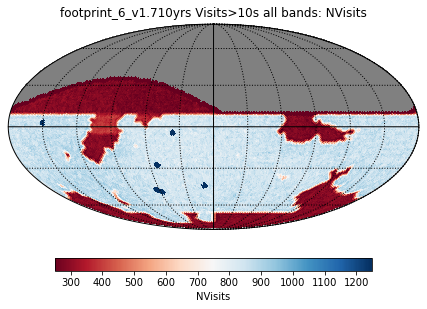

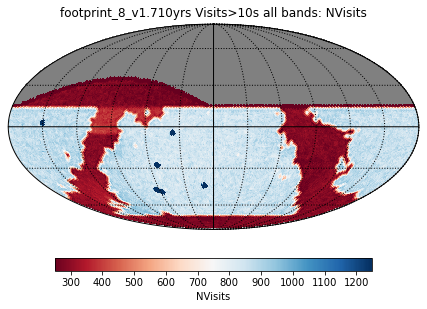

In [33]:
ph = plots.PlotHandler(savefig=False, thumbnail=False)

for i in simlist:
    f = 1.0
    if families.summaries['NumExp'].loc[i] == 1:
        f = 1/0.922
    ph.setMetricBundles([bundles[i]])
    plotDicts = {'cmap': 'RdBu', 'colorMin': 250*f, 'colorMax': 1250*f}
    ph.plot(plotFunc=plots.HealpixSkyMap(), plotDicts=plotDicts)

### How much area is practical to cover?

This is a ballpark estimate! 
Taking the average number of visits from the 2x15s simulations, we can obtain about 2.06M visits over the course of 10 years. 

In [20]:
# Average number of visits in simulations with two exposures
tt = families.summaries['Nvisits All props'][families.summaries['NumExp'] == 2]
np.mean(tt), np.min(tt), np.max(tt), np.median(tt)

(2090473.6144578313, 1947985.0, 3013478.0, 2045493.0)

In the simulations listed above, we cover varying amounts of area, but with different amounts of the total time devoted to WFD, ranging from 70% to just over 80%.  In general, though we need about 1.7M (about 80% of the total) visits to cover a 18k sq degree WFD, based on looking at the `wfd_depth` family and where the fOArea Min crosses the 18k sq deg boundary. 

In [34]:
# Pull up the information from the wfd_depth family. This is a 1x30s family, 
# however the number of visits required to cover the WFD doesn't need to be scaled here 
# because we're looking for the actual number of visits needed to cover 18k sq deg
wf = pd.DataFrame([families.summaries['fOArea Min'].loc[families.family['wfd_depth']],  
                  families.summaries['Nvisits WFD'].loc[families.family['wfd_depth']],
                  families.summaries['Nvisits Long Exp'].loc[families.family['wfd_depth']]]).T
wf

,fOArea Min,Nvisits WFD,Nvisits Long Exp
baseline_v1.5_10yrs,18252.118902,1851875.0,2224095.0
wfd_depth_scale0.65_noddf_v1.5_10yrs,16675.925437,1583579.0,2227379.0
wfd_depth_scale0.70_noddf_v1.5_10yrs,20181.654993,1647459.0,2227429.0
wfd_depth_scale0.75_noddf_v1.5_10yrs,18425.852687,1718787.0,2226780.0
wfd_depth_scale0.80_noddf_v1.5_10yrs,18309.190870,1795290.0,2226618.0
wfd_depth_scale0.85_noddf_v1.5_10yrs,18348.637672,1874046.0,2226787.0
wfd_depth_scale0.90_noddf_v1.5_10yrs,18437.602798,1947907.0,2225486.0
wfd_depth_scale0.95_noddf_v1.5_10yrs,18497.192647,2026223.0,2225655.0
wfd_depth_scale0.99_noddf_v1.5_10yrs,18522.371456,2095078.0,2226029.0
wfd_depth_scale0.65_v1.5_10yrs,7397.534189,1510282.0,2225715.0


We can also look at the simulations above where the area varied a bit further. We find similar kinds of results; just under 1.7M visits (~80% of the total visits) covers an 18k sq degree area. Some simulations with much larger area don't use more total visits to cover that area; however, these simulations generally get a smaller number of visits per pointing.

In [35]:
# Estimate number of visits devoted to WFD - (these are adjusted already for 2 vs 1 snap)
# median number of visits per pointing / total visits scales with percent time WFD
# area * median number of visits per pointing scales with percent time WFD
# So together we can use this as a way to count the approximate number of visits spent on WFD
t = d['fOArea Min'] * d['Median Nvisits per pointing*'] / d['Total Nvisits*'] 

# Scale t to match for baseline_nexp2_v1.7_10yrs (which had about 1700793 visits in WFD)
magic = 1700793 / (d['Total Nvisits*'].loc['baseline_nexp2_v1.7_10yrs'] * t.loc['baseline_nexp2_v1.7_10yrs'])
t = t * magic

scale = pd.DataFrame([d['fOArea Min'], d['Median Nvisits per pointing*'],
                      d['fOArea Min']*d['Median Nvisits per pointing*'], 
                      d['Total Nvisits*'], d['Total Nvisits*'] * t, t],
                     index=['Area', 'NvisitPerPoint*', 'AxNvis', 'Total Visits*', 'Visits*', 't']).T
scale

,Area,NvisitPerPoint*,AxNvis,Total Visits*,Visits*,t
baseline_nexp2_v1.7_10yrs,18233.654442,888.000,1.619149e+07,2045493.000,1.700793e+06,0.831483
footprint_gp_smoothv1.5_10yrs,20123.743731,837.176,1.684712e+07,2050300.266,1.769662e+06,0.863123
bulges_cadence_bs_v1.5_10yrs,19365.022276,803.984,1.556917e+07,2055496.658,1.635423e+06,0.795634
wfd_depth_scale0.70_noddf_v1.5_10yrs,20181.654993,796.608,1.607687e+07,2053689.538,1.688753e+06,0.822302
combo_dust_nexp2_v1.6_10yrs,19437.201529,817.000,1.588019e+07,2069774.000,1.668094e+06,0.805931
footprint_6_v1.710yrs,18638.193979,856.000,1.595429e+07,2044789.000,1.675878e+06,0.819585
footprint_8_v1.710yrs,17910.526389,860.000,1.540305e+07,2050183.000,1.617974e+06,0.789185


Text(0.5, 1.0, 'Trading Area vs. Visits per Pointing')

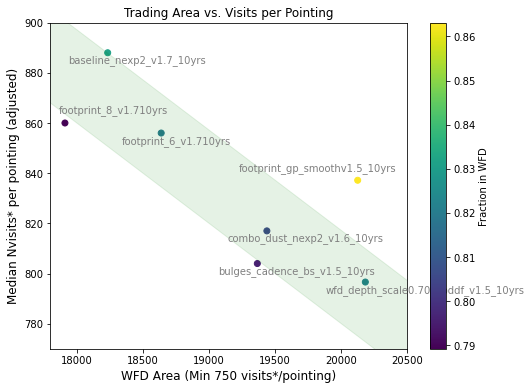

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(x=scale['Area'], y=scale['NvisitPerPoint*'], c=scale['t'])
for count, (i, row) in enumerate(scale.iterrows()):
    if row.name == 'footprint_8_v1.710yrs':
        xy = (row['Area']-50, row['NvisitPerPoint*']+4)
    elif row.name == 'baseline_nexp2_v1.7_10yrs':
        xy = (row['Area']-300, row['NvisitPerPoint*']-4)
    elif row.name == 'footprint_gp_smoothv1.5_10yrs':
        xy = (row['Area']-900, row['NvisitPerPoint*']+4)
    else:
        xy = (row['Area']-300, row['NvisitPerPoint*']-4)
    plt.annotate(text=row.name, xy=xy, color='gray')
    
x = np.arange(17000, 22000, 100)
y1 = (18230 - x) * .04  + 888 # ~83%
y2 = (18000 - x) * .04  + 860 # ~80%
plt.fill_between(x, y1, y2, color='green', alpha=0.1)
y = (19000 - x) * 0.04 + 843 # 82%
#plt.plot(x, y2)
plt.xlim(17800, 20500)
plt.ylim(770, 900)
    
plt.colorbar(label='Fraction in WFD')
plt.xlabel("WFD Area (Min 750 visits*/pointing)", fontsize='large')
plt.ylabel("Median Nvisits* per pointing (adjusted)", fontsize='large')
plt.title("Trading Area vs. Visits per Pointing", fontsize='large')

This shows clearly the trade between number of visits per pointing vs. area in the WFD, and some indications of how it changes with different fractions of time devoted to WFD.
The limitations on how much time is devoted to WFD are somewhat flexible, however we see above in the `wfd_depth` family that 80% of the total number of visits tends to be the lowest practical limit when using 2x15s visits (if we had 1x30s visits and gained 9% in the total number of visits, we could reach 18k sq deg in only 70% of the total number of visits, but this is NOT a choice we can make at this time). 

At the upper limit, in the recent FBS simulations, we have chosen 5% of the time to use for DD fields. We likely need to reserve another 1-2% of time for mini-minisurveys and ToO's, etc.  Most likely we will need another 2-4% of time for surveying areas outside the WFD footprint, to preserve various core science goals. This leaves around a maximum amount of time available for WFD visits of about 90% of the total (and potentially less, depending on how the WFD footprint is defined, which may require more visits outside the WFD). 

We also need to hold some time (visits) in reserve, to ensure that weather or mechanical problems don't bring the number of visits per WFD pointing below the minimum requirements. This is time that should not be spent to make the WFD larger in *area*, but instead to boost the *number of visits per pointing*. It is prudent to reserve on the order of at least 5% and perhaps up to 10% for this; if we assume 8% for this contingency requirement, then this leaves us with an upper limit of about 82% of time 'available to increase area'.

With 82% of the total survey time devoted to WFD, we could cover approximately 18k sq degrees with a median of 880 visits per pointing, or about 19k sq degrees with a median of about 825 visits per pointing, or 20k sq degrees with a median perhaps around 800 visits per pointing. This range is approximately represented by the green stripe in the plot. (remember that with the 8% extra time, we could increase the number of visits over a fixed area, but that science should not fail if that reserve is absorbed by weather downtime).

(edge effects will decrease these areas slightly, and depending on the details of the footprint location, over or under subscription due to DD field locations and weather and planned shutdowns may make coverage more or less uneven).

In [37]:
mlist = ['Nvisits Long Exp', 'fONv MedianNvis fO All visits HealpixSlicer', 
         'fOArea Min',# 'fOArea Goal', 'fOArea Stretch',
        'Effective Area (deg) ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer',
        ]
mlist_shortnames = ['Total Nvisits*', 'Median Nvisits per pointing*',
                    'fOArea Min', #'fOArea Goal', 'fOArea Stretch',
                    'Dust-free deep area']

dall = families.summaries[mlist].copy()

# Scale the nvisits metric results down to match 9% fewer overall visits
# Note that the fOArea metrics *here* already reflect this scaling; 
# effective area does not but may not be as sensitive.
visitmetrics = ['Nvisits Long Exp', 'fONv MedianNvis fO All visits HealpixSlicer']
onesnap = np.where(families.summaries['NumExp'] == 1)
for r in dall.index.values[onesnap]:
    for m in visitmetrics:
        dall[m].loc[r] = dall[m].loc[r] * 0.922
dall.columns = mlist_shortnames

t = dall['fOArea Min'] * dall['Median Nvisits per pointing*'] / dall['Total Nvisits*'] 

# Scale t to match for baseline_nexp2_v1.7_10yrs (which had about 1700793 visits in WFD)
magic = 1700793 / (dall['Total Nvisits*'].loc['baseline_nexp2_v1.7_10yrs'] * t.loc['baseline_nexp2_v1.7_10yrs'])
t = t * magic

scale = pd.DataFrame([dall['fOArea Min'], dall['Median Nvisits per pointing*'],
                      dall['fOArea Min']*dall['Median Nvisits per pointing*'], 
                      dall['Total Nvisits*'], dall['Total Nvisits*'] * t, t],
                     index=['Area', 'NvisitPerPoint*', 'AxNvis', 'Total Visits*', 'Visits*', 't']).T
scale

,Area,NvisitPerPoint*,AxNvis,Total Visits*,Visits*,t
baseline_samefilt_v1.5_10yrs,18362.905664,924.766,1.698139e+07,2130385.186,1.783767e+06,0.837298
agnddf_v1.5_10yrs,18237.850910,885.120,1.614269e+07,2010514.122,1.695667e+06,0.843400
alt_dust_v1.5_10yrs,17867.722413,827.956,1.479369e+07,2059377.356,1.553965e+06,0.754580
baseline_v1.5_10yrs,18252.118902,891.574,1.627311e+07,2050615.590,1.709368e+06,0.833588
bulges_bs_v1.5_10yrs,19375.933093,803.984,1.557794e+07,2055501.268,1.636345e+06,0.796081
...,...,...,...,...,...,...
u_long_ms_40_v1.7_10yrs,18217.707863,889.000,1.619554e+07,2046486.000,1.701219e+06,0.831288
u_long_ms_60_v1.7_10yrs,18167.350244,915.000,1.662313e+07,1986422.000,1.746134e+06,0.879035
twi_pairs_mixed_v1.7_10yrs,18240.368791,885.000,1.614273e+07,2038077.000,1.695671e+06,0.831996
twi_pairs_repeat_v1.7_10yrs,18238.690204,893.000,1.628715e+07,2056507.000,1.710842e+06,0.831916


Text(0.5, 1.0, 'Trading Area vs. Visits per Pointing')

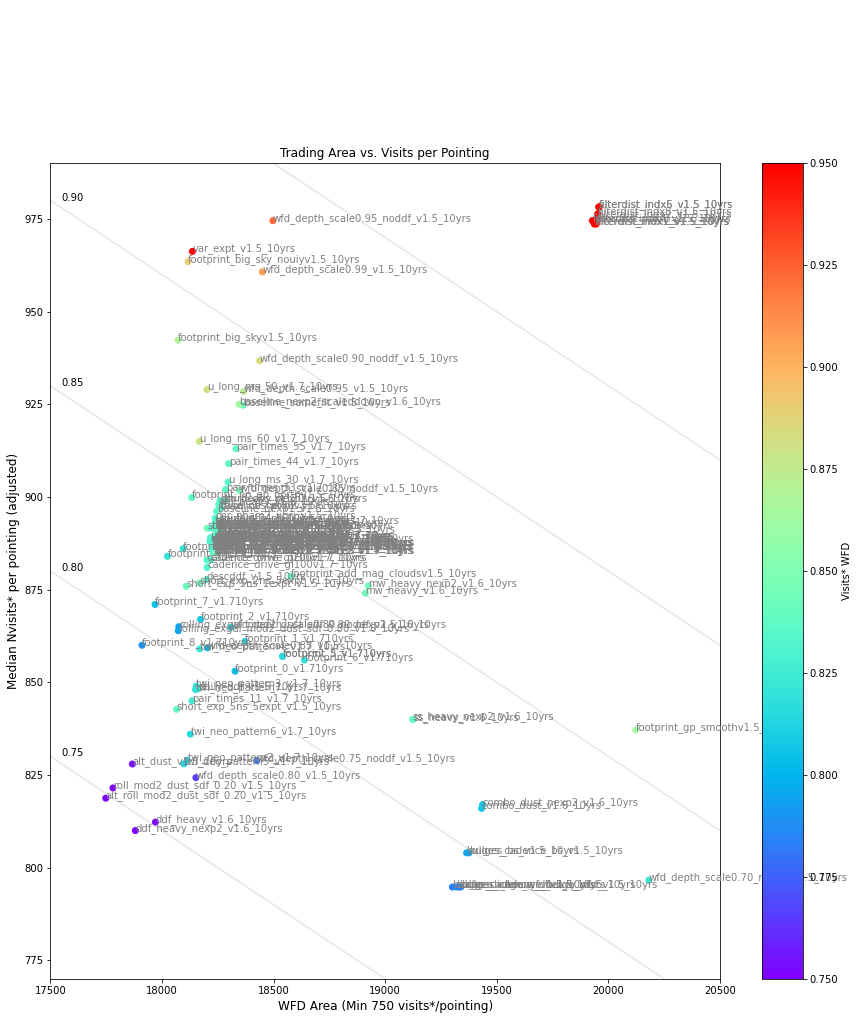

In [40]:
plt.figure(figsize=(15,15))

s = scale.loc[runs]

plt.scatter(x=s['Area'], y=s['NvisitPerPoint*'], c=s['t'], vmin=0.75, vmax=0.95, cmap='rainbow')
for count, (i, row) in enumerate(s.iterrows()):
    xy = (row['Area'], row['NvisitPerPoint*'])
    if xy[0] > 17500 and xy[1] < 1000:
        #pass
        plt.annotate(text=row.name, xy=xy, color='gray')
    
x = np.arange(17000, 22000, 100)
for i in np.arange(75, 100, 5):
    y = (18000 - x) * .04  + 860 + (i - 80) * 10 
    plt.plot(x, y, color='gray', linestyle='-', alpha=0.2)
    x0 = 17550
    y0 = (18000 - x0) * .04  + 860 + (i - 80) * 10 
    plt.annotate('%.02f' % (i/100), (x0, y0+2))
plt.xlim(17500, 20500)
plt.ylim(770, 990)
    
plt.colorbar(label='Visits* WFD')
plt.xlabel("WFD Area (Min 750 visits*/pointing)", fontsize='large')
plt.ylabel("Median Nvisits* per pointing (adjusted)", fontsize='large')
plt.title("Trading Area vs. Visits per Pointing", fontsize='large')